# Importing necessary packages, loading in data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_cars = pd.read_csv("https://raw.githubusercontent.com/NigelPetersen/UsedCars/main/raw_cars_data.csv")
raw_cars.columns

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state',
       'drivetrain', 'price_usd', 'is_exchangeable', 'location_region',
       'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'duration_listed'],
      dtype='object')

# Data cleaning and feature engineering

In [4]:
nuissance_variables = ["engine_fuel", "up_counter", "has_warranty", "number_of_photos",
                       "engine_has_gas", "state", "is_exchangeable"]
raw_cars = raw_cars.drop(columns = nuissance_variables, axis = 1)

raw_cars = raw_cars.loc[raw_cars["price_usd"] >= 250]

In [5]:
def get_counts(my_data, variable):
    count_data = my_data.groupby([variable]).agg(
        Count = pd.NamedAgg(column = variable, aggfunc = "count")
    )
    count_data["Proportion"] = np.round(100*count_data["Count"]/len(my_data), 2)
    return count_data.sort_values(by = ["Count"], ascending = False).reset_index()

In [6]:
features = ["feature_" + str(i) for i in range(10)]
raw_cars["feature_count"] = raw_cars[features].sum(axis = 1).apply(str)
raw_cars = raw_cars.drop(columns = features, axis = 1)

regions = raw_cars["location_region"].unique()
new_regions = ["Region_" + str(i+1) for i in range(len(regions))]
raw_cars["location_region"] = raw_cars["location_region"].replace(regions, new_regions)

raw_cars["transmission"] = raw_cars["transmission"].replace(["mechanical"], ["manual"])

raw_cars["log_price"] = np.log(raw_cars["price_usd"])

manufacturer_counts = get_counts(raw_cars, "manufacturer_name")
popular_brands = manufacturer_counts.loc[manufacturer_counts["Proportion"] > 1]["manufacturer_name"]
body_type_counts = get_counts(raw_cars, "body_type")
popular_body_types = body_type_counts.loc[body_type_counts["Proportion"] > 5]["body_type"]
raw_cars = raw_cars.loc[(raw_cars["manufacturer_name"].isin(popular_brands)) &
 (raw_cars["body_type"].isin(popular_body_types)) & (raw_cars["year_produced"] >= 1990)]

color_counts = get_counts(raw_cars, "color")
other_colors = list(color_counts.loc[color_counts["Proportion"] < 5]["color"])
raw_cars["color"] = raw_cars["color"].replace(other_colors, "other")

cars_data = raw_cars.dropna().reset_index(drop = True)

<ipython-input-6-f8f4285811b8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cars["color"] = raw_cars["color"].replace(other_colors, "other")


# Preliminary plots and analysis

In [7]:
sns.set(rc={'figure.figsize':(12,8)}, style = "whitegrid")

def frequency_plot(my_data, variable, labels, horizontal = True):
    if horizontal:
        my_plot = sns.barplot(x = "Count", y = variable, data = get_counts(my_data, variable))
        my_plot.set(xlabel = "Counts", ylabel = labels[0], title = labels[1])

    else:
        my_plot = sns.barplot(x = variable, y = "Count", data = get_counts(my_data, variable))
        my_plot.set(xlabel = labels[0], ylabel = "Counts", title = labels[1])
    return my_plot

def facet_frequency_plot(my_data, variable, facet_variable, labels):
    plot_data = my_data.groupby([variable, facet_variable]).agg(
        Count = pd.NamedAgg(column = variable, aggfunc = "count")
    ).sort_values(by = ["Count"], ascending = False).reset_index()

    my_plot = sns.barplot(x = "Count", y = variable, hue = facet_variable, data = plot_data)
    my_plot.set(xlabel = "Counts", ylabel = labels[0], title = labels[1])
    return my_plot

def boxplot_against_response(my_data, variable, response, labels, plot_median = True):
    my_plot = sns.boxplot(x = response, y = variable, data = my_data)
    my_plot.set(xlabel = labels[0], ylabel = labels[1], title = labels[2])
    if plot_median:
        my_plot.axvline(x = np.median(my_data[response]), color = "red", linestyle = "dashed")
    return my_plot

def facet_boxplot_against_response(my_data, variable, response, facet_variable, labels):
    plot_data = my_data.sort_values(by = [response], ascending = False)
    my_plot = sns.boxplot(x = response, y = variable, hue = facet_variable, data = plot_data)
    my_plot.set(xlabel = labels[0], ylabel = labels[1], title = labels[2])
    sns.move_legend(my_plot, "upper right")
    return my_plot

categorical_variables = ["manufacturer_name", "transmission", "color", "engine_type",
                         "body_type", "drivetrain", "location_region", "feature_count"]

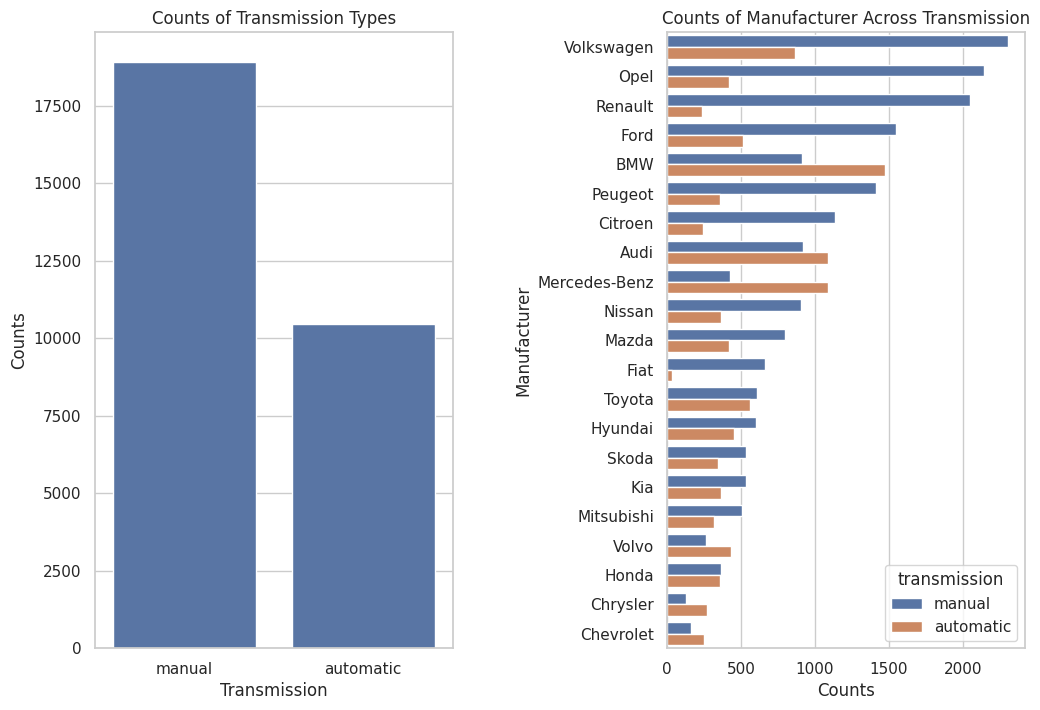

In [7]:
fig = plt.figure()
fig.subplots_adjust(wspace = 0.6)
ax = fig.add_subplot(1,2,1)
frequency_plot(cars_data, "transmission", ["Transmission", "Counts of Transmission Types"], horizontal = False)
ax = fig.add_subplot(1,2,2)
facet_frequency_plot(cars_data, "manufacturer_name", "transmission",
 ["Manufacturer", "Counts of Manufacturer Across Transmission"])
plt.show()

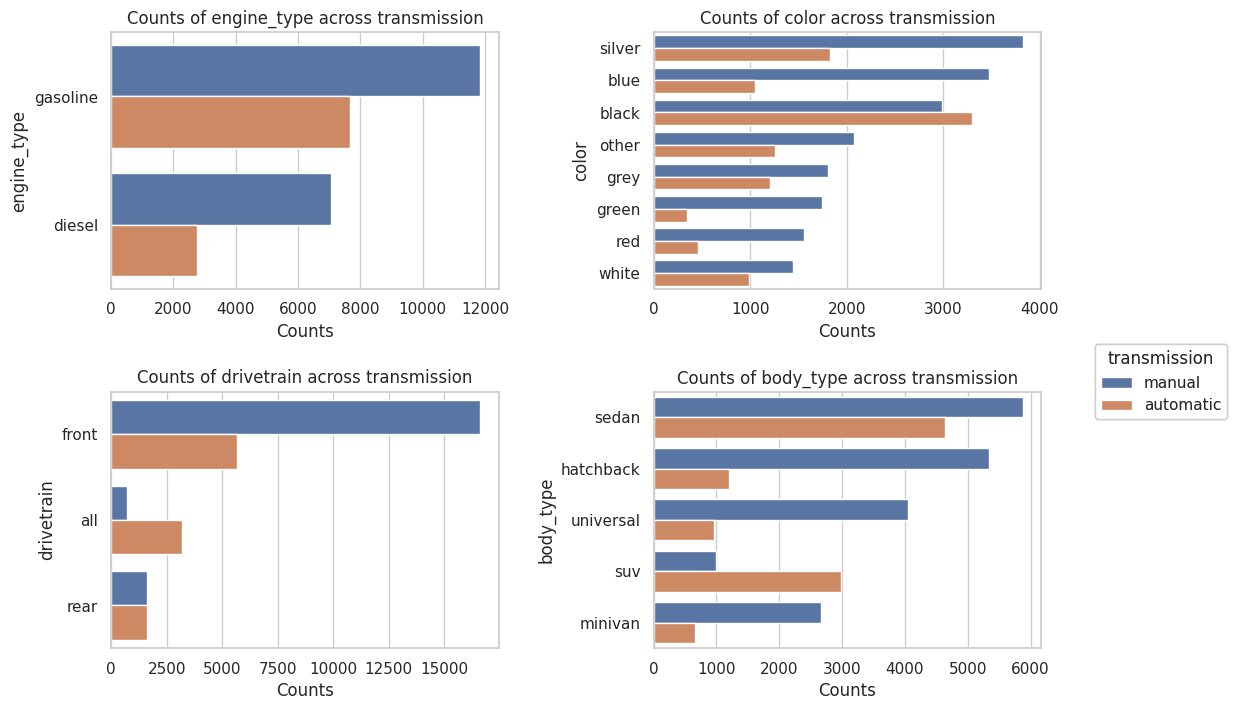

In [8]:
plotting_variables = ["engine_type", "color", "drivetrain", "body_type"]
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)
for i in range(len(plotting_variables)):
    ax = fig.add_subplot(2,2,i+1)
    variable = plotting_variables[i]
    plot = facet_frequency_plot(cars_data, variable, "transmission",
     [variable, "Counts of " + variable + " across transmission"])
    sns.move_legend(plot, loc = "upper center", bbox_to_anchor = (1, 0.5), bbox_transform = plt.gcf().transFigure)
plt.show()

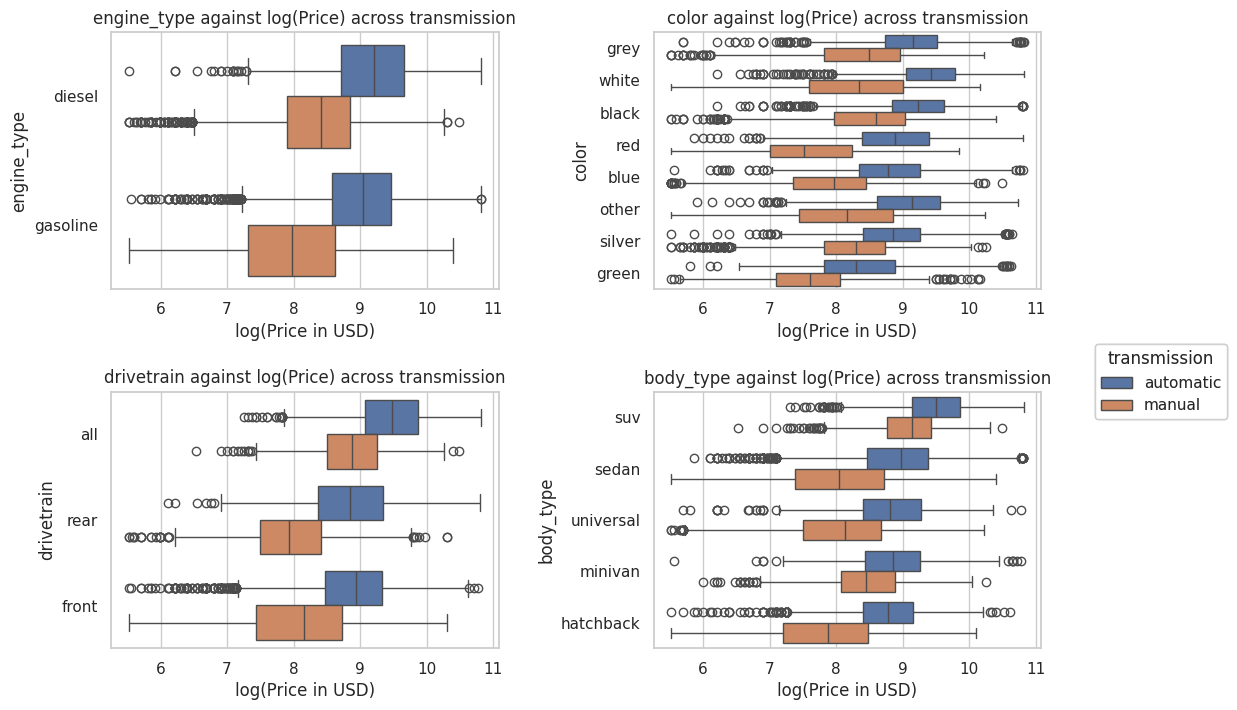

In [9]:
fig = plt.figure()
fig.subplots_adjust(wspace = 0.4, hspace = 0.4)
for i in range(len(plotting_variables)):
    ax = fig.add_subplot(2,2,i+1)
    variable = plotting_variables[i]
    plot = facet_boxplot_against_response(cars_data, variable, "log_price", "transmission",
     ["log(Price in USD)", variable, variable + " against log(Price) across transmission"])
    sns.move_legend(plot, loc = "upper center", bbox_to_anchor = (1, 0.5), bbox_transform = plt.gcf().transFigure)
plt.show()

In [ ]:
good_manufacturers = ["Honda", "Toyota", "Volkswagen", "Mercedes-Benz", "BMW",
                    "Hyundai", "Mitsubishi", "Kia", "Audi",
                    "Nissan", "Mazda"]
cars_data = cars_data.loc[cars_data["manufacturer_name"].isin(good_manufacturers)]

cars_data["Mileage"] = (cars_data["odometer_value"] > 300000).apply(str)
cars_data["Mileage"] = cars_data["Mileage"].replace(["True", "False"], ["> 300000 km", "< 300000 km"])
cars_data = cars_data.loc[cars_data["odometer_value"] < 500000]

cars_data["Production Era"] = (cars_data["year_produced"] >= 2008).apply(str)
cars_data["Production Era"] = cars_data["Production Era"].replace(["True", "False"], ["> 2008", "< 2008"])

fig = plt.figure()
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)

ax = fig.add_subplot(2,2,1)
density_plot = sns.kdeplot(x = "odometer_value", fill = True, hue = "transmission", data = cars_data)
density_plot.ticklabel_format(style = "plain")
ax.tick_params(axis = 'x', rotation = -45)
density_plot.axvline(x = np.mean(cars_data.loc[cars_data["transmission"] == "manual"]["odometer_value"]),
                     color = "b", linestyle = "dashed")
density_plot.axvline(x = np.mean(cars_data.loc[cars_data["transmission"] == "automatic"]["odometer_value"]),
                     color = "orange", linestyle = "dashed")
density_plot.set(xlabel = "Odometer Value", title = "Odometer Value Density")

ax = fig.add_subplot(2,2,2)
plot = facet_boxplot_against_response(cars_data, "manufacturer_name", "log_price", "Mileage",
 ["log(Price in USD)", "Manufacturer", "log(Price) against Manufacturer across Mileage"])
sns.move_legend(plot, loc = "upper center", bbox_to_anchor = (1, 0.75), bbox_transform = plt.gcf().transFigure)

ax = fig.add_subplot(2,2,3)
de_plot = sns.kdeplot(x = "year_produced", fill = True, hue = "transmission", data = cars_data)
de_plot.set(xlabel = "Production Year", ylabel = "Density", title = "Density of Production Year")
de_plot.axvline(x = 2008, color = "red", linestyle = "dashed")
ax = fig.add_subplot(2,2,4)
plot = facet_boxplot_against_response(cars_data, "manufacturer_name", "log_price", "Production Era",
        ["log(Price in USD)", "Manufacturer", "log(Price) against Manufacturer across Production Era"])
sns.move_legend(plot, loc = "upper center", bbox_to_anchor = (1, 0.25), bbox_transform = plt.gcf().transFigure)
plt.show()

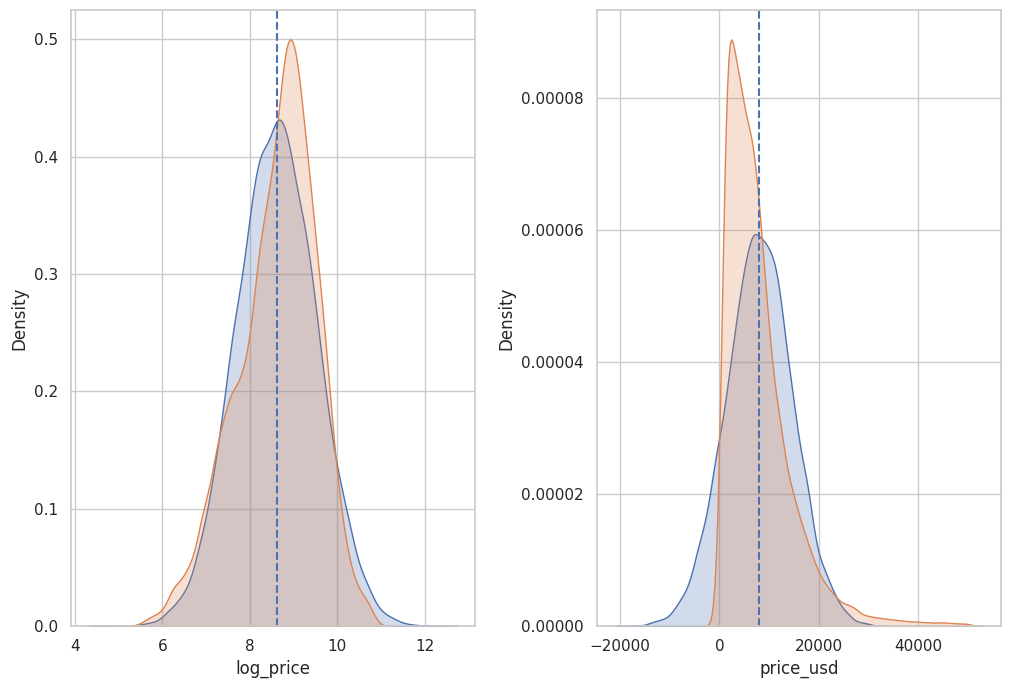

In [122]:
log_normal_dist = np.random.normal(loc = np.mean(cars_data["log_price"]),
                                   scale = np.std(cars_data["log_price"]), size = len(cars_data))
normal_dist = np.random.normal(loc = np.mean(cars_data["price_usd"]),
                               scale = np.std(cars_data["price_usd"]), size = len(cars_data))

fig = plt.figure()
fig.subplots_adjust(wspace = 0.3)
ax = fig.add_subplot(1,2,1)
true_plot = sns.kdeplot(log_normal_dist, fill = True)
observed_plot = sns.kdeplot(x = "log_price", fill = True, data = cars_data)
observed_plot.axvline(x = np.mean(cars_data["log_price"]), color = "b", linestyle = "dashed")

ax = fig.add_subplot(1,2,2)
true_plot = sns.kdeplot(normal_dist, fill = True)
observed_plot = sns.kdeplot(x = "price_usd", fill = True, data = cars_data)
observed_plot.axvline(x = np.mean(cars_data["price_usd"]), color = "b", linestyle = "dashed")
observed_plot.ticklabel_format(style = "plain")
plt.show()

In [ ]:
cars_data.columns

# More preprocessing, model fitting

In [9]:
import sklearn
from sklearn.linear_model import LinearRegression

model_data = cars_data.drop(columns = ["Mileage", "Production Era", "log_price", "price_usd"])
model_data["engine_capacity"] = model_data["engine_capacity"].apply(str)
my_features = pd.get_dummies(model_data)

log_price = cars_data["log_price"]

regression_model = LinearRegression().fit(my_features, log_price)